<a href="https://colab.research.google.com/github/leechungpa/FinancialEngineering-intro/blob/master/final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network 모형을 활용하여, Put-Call Parity 에 따른 이자율 예측

![](https://raw.githubusercontent.com/leechungpa/FinancialEngineering-intro/master/docs/Put-call%20Parity.png)

Put-call parity 공식에 따르면 $c-p=S_{0}-K/r$ 이 성립한다. 즉 현재시점에서 $c$와 $p$와 $S_{0}$와 $K$를 알 수 있기에 차익거래가 존재하지 않는다면 사람들이 생각하는 이자율을 예측할 수 있다. 그래서 우리는 이 공식을 이용해 데이터를 만들어 보고, 해당데이터를 이용해 이자율을 예측하는 모형을 만들어 보고자 한다.

데이터를 만들 때 2가지의 방식으로 만들고자 한다. 먼저 정확한 공식에 따라 데이터를 만든 경우이다. 그리고 두번째는 임의의 오차를 준 경우이다. 우리는 공식에 따라 $S_{0}$를 계산해 데이터를 만들 것인데, 오차를 임의의 0.9~1.1 값을 배하여 구하였다.

또한 사람들이 생각하는 이자율은 다 다를 수 있으나, 특정한 값 근처에 몰릴 것이라고 판단해, 특정값(현 기준금리인 0.75)에 근접한 분포를 이용해 put-call parity 공식을 활용해 test data set을 만들고, 만든 모형이 0.75에 근접한 값을 보이는지 확인해 보고자 한다.

In [0]:
from random import *
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

## 데이터 생성

In [0]:
# put-call parity 공식
def put_call_parity(c,p,K,r):
  value = c - p + K/r
  return value

# put-call parity 공식 및 오차 반영
def put_call_parity_with_error(c,p,K,r,error = 0):
  value = put_call_parity(c,p,K,r)*uniform(1-error, 1+error)
  return value

In [0]:
# Data Frame 생성
def make_df(n=1000, error=0) :
  # n : 만들 데이터 수 
  temp_df = pd.DataFrame(columns=['c', 'p', 's', 'K', 'r'])
  i=0
  while i != n :
    c = randint(20,200)
    p = randint(20,200)
    K = randint(20,200)
    r = random()+0.5
    if c > p :
      temp_df.loc[i]=[c, p, put_call_parity_with_error(c,p,K,r,error=error), K, r]
      i=i+1
  return temp_df

In [0]:
pcp_df = make_df(error=0.1)
pcp_df.tail()

,c,p,s,K,r
995,144.0,91.0,152.897963,94.0,1.012309
996,199.0,151.0,210.517897,197.0,1.317618
997,87.0,71.0,35.274855,25.0,1.291588
998,157.0,23.0,403.338697,159.0,0.587729
999,177.0,148.0,114.461927,62.0,0.709756


In [0]:
pcp_X = np.array(pcp_df.loc[:,['c','p','s','K']])
pcp_Y = np.array(pcp_df.loc[:,'r'])

## 모델 생성

In [0]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Dense(3, input_shape=[4],activation='relu'),
    tf.keras.layers.Dense(1)  #Dense 레이어의 경우 2번째 레이어 부터는 input_shape 필요 없음
]) 
my_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 4         
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


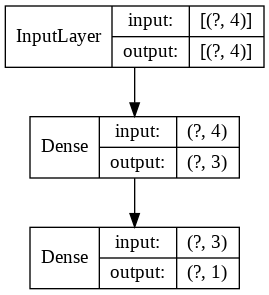

In [0]:
tf.keras.utils.plot_model( my_model, show_shapes=True, show_layer_names=False )

In [0]:
my_model.compile(
    loss = 'mse',
    optimizer = 'adam'
)
my_model.fit(pcp_X, pcp_Y ,epochs=1000,verbose=False) # vaerbose하면 결과를 간단히 보여줌

In [0]:
my_model.get_weights()

[array([[ 0.2390846 ,  0.49666727, -0.07849006],
        [ 0.05169167,  0.27153474, -0.2192551 ],
        [ 0.60577846,  0.7782774 ,  0.5341023 ],
        [ 0.316755  , -0.24915865,  1.1470134 ]], dtype=float32),
 array([ 0.43826663, -0.37926897, -0.21029848], dtype=float32),
 array([[ 0.72378176],
        [-0.38016823],
        [-0.27654055]], dtype=float32),
 array([0.44016832], dtype=float32)]

## 모델 test

In [0]:
# test data set 생성
test_df = pd.DataFrame(columns=['c', 'p', 's', 'K', 'r'])
i=0
r=0.75
while i != 200 :
  c = randint(20,200)
  p = randint(20,200)
  K = randint(20,200)
  if c > p :
    test_df.loc[i]=[c, p, put_call_parity_with_error(c,p,K,r,error=0.1), K, r]
    i=i+1

In [0]:
test_X = np.array(test_df.loc[:,['c','p','s','K']])
test_Y = np.array(test_df.loc[:,'r'])

In [0]:
result = my_model.predict(test_X)

## 시각화

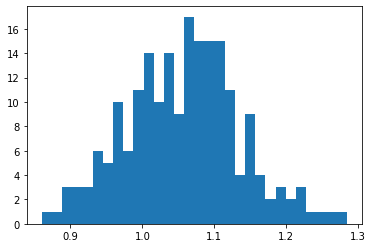

In [0]:
plt.figure()
plt.hist(result,bins=30)
plt.show()

# 더 복잡한 모형이 있다면...

In [0]:
my_model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(9, input_shape=[4],activation='relu'),
    tf.keras.layers.Dense(3, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
]) 
my_model2.compile(
    loss = 'mse',
    optimizer = 'adam'
)
my_model2.fit(pcp_X, pcp_Y ,epochs=2000,verbose=False) # vaerbose하면 결과를 간단히 보여줌

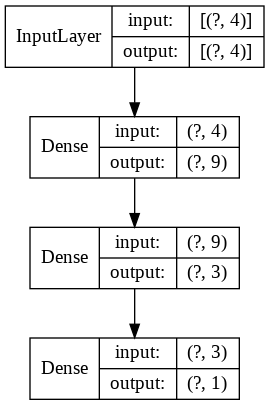

In [0]:
tf.keras.utils.plot_model( my_model2, show_shapes=True, show_layer_names=False )

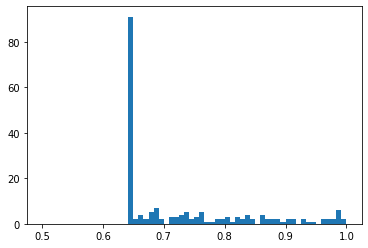

In [0]:
result2 = my_model.predict(test_X)

plt.figure()
plt.hist(result2,bins=60, range=[0.5, 1])
plt.show()